# Ridership analysis
In this notebook we tried to understand how ridership is being distributed and how can it value add in identifying routes to remove or reroute

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
bus_routes = pd.read_json('../data/cleaned/BusRoutes.json', lines=True)
bus_ridership_202409 = pd.read_csv('../data/cleaned/BusRideVolume202409.csv', dtype={'PT_CODE': int})

In [26]:
bus_routes.head()

,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,WD_FirstBus,WD_LastBus,SAT_FirstBus,SAT_LastBus,SUN_FirstBus,SUN_LastBus
0,10,SBST,1,1,75009,0.0,0500,2300,0500,2300,0500,2300
1,10,SBST,1,2,76059,0.6,0502,2302,0502,2302,0502,2302
2,10,SBST,1,3,76069,1.1,0504,2304,0504,2304,0503,2304
3,10,SBST,1,4,96289,2.3,0508,2308,0508,2309,0507,2308
4,10,SBST,1,5,96109,2.7,0509,2310,0509,2311,0508,2309


In [29]:
bus_ridership_202409.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2024-09,WEEKENDS/HOLIDAY,5.0,BUS,59239,35,27
1,2024-09,WEEKENDS/HOLIDAY,10.0,BUS,64241,772,380
2,2024-09,WEEKDAY,18.0,BUS,53241,907,1534
3,2024-09,WEEKDAY,20.0,BUS,11161,4363,5982
4,2024-09,WEEKENDS/HOLIDAY,13.0,BUS,70041,565,495


### Understanding the ridership data in general

In [30]:
average_ridership_by_stop = bus_ridership_202409.groupby(['TIME_PER_HOUR', 'DAY_TYPE']).agg({
    'TOTAL_TAP_IN_VOLUME': ['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    'TOTAL_TAP_OUT_VOLUME': ['mean', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
}).reset_index()
average_ridership_by_stop.columns = ['TIME_PER_HOUR', 'DAY_TYPE', 'TAP_IN_MEAN', 'TAP_IN_25', 'TAP_IN_75', 'TAP_OUT_MEAN', 'TAP_OUT_25', 'TAP_OUT_75']

In [6]:
average_ridership_by_stop.head()

,TIME_PER_HOUR,DAY_TYPE,TAP_IN_MEAN,TAP_IN_25,TAP_IN_75,TAP_OUT_MEAN,TAP_OUT_25,TAP_OUT_75
0,0.0,WEEKDAY,64.845067,3.0,34.0,94.574234,10.0,111.0
1,0.0,WEEKENDS/HOLIDAY,34.155139,1.0,18.0,49.713103,6.0,58.0
2,1.0,WEEKDAY,7.057034,0.0,4.0,16.459533,2.0,18.0
3,1.0,WEEKENDS/HOLIDAY,3.771991,0.0,3.0,9.078125,2.0,10.0
4,2.0,WEEKDAY,1.422222,0.0,3.0,2.200000,1.0,2.0


Plot ridership data by time of hour for tap in/tap out volume and whether or not it is a weekday

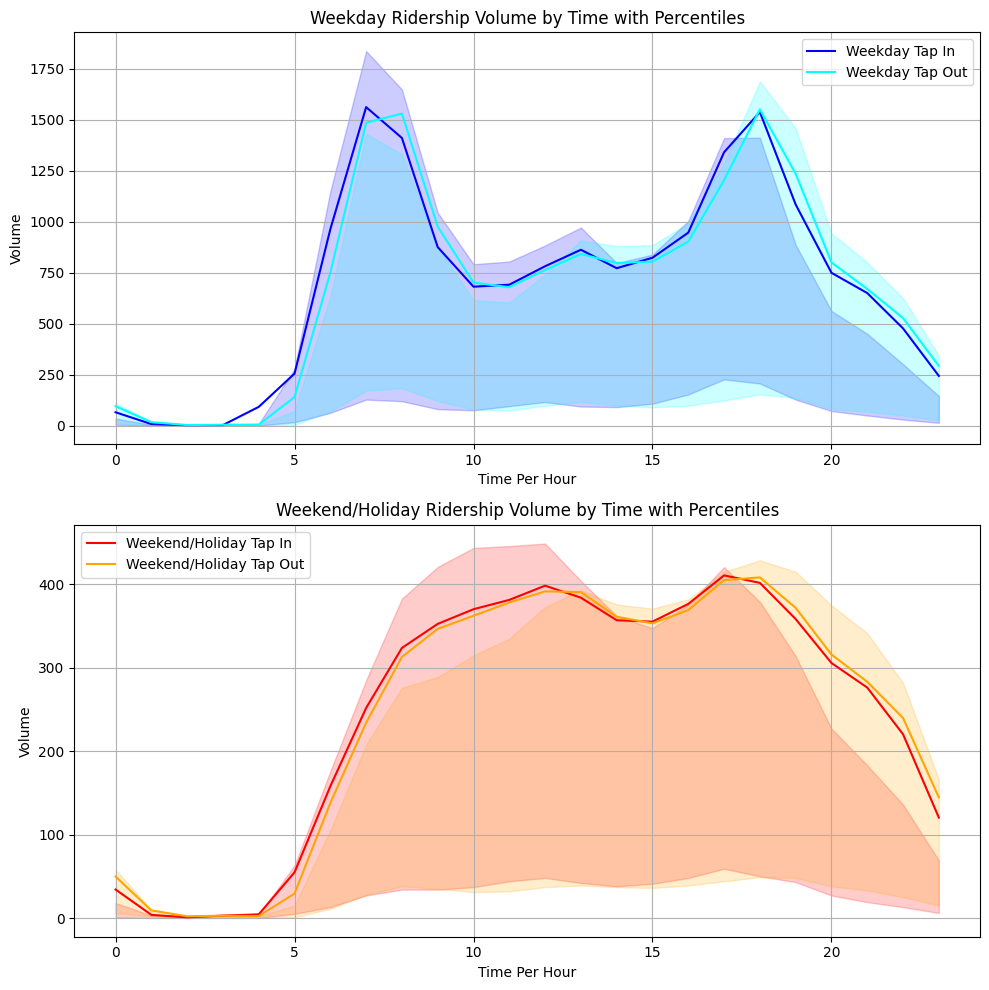

In [7]:
# Filter data for weekdays and weekends/holidays
weekdays = average_ridership_by_stop[average_ridership_by_stop['DAY_TYPE'] == 'WEEKDAY']
weekends = average_ridership_by_stop[average_ridership_by_stop['DAY_TYPE'] == 'WEEKENDS/HOLIDAY']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot for weekdays with shaded area
axes[0].plot(weekdays['TIME_PER_HOUR'], weekdays['TAP_IN_MEAN'], label='Weekday Tap In', color='blue')
axes[0].fill_between(weekdays['TIME_PER_HOUR'],
                     weekdays['TAP_IN_25'],
                     weekdays['TAP_IN_75'],
                     color='blue', alpha=0.2)
axes[0].plot(weekdays['TIME_PER_HOUR'], weekdays['TAP_OUT_MEAN'], label='Weekday Tap Out', color='cyan')
axes[0].fill_between(weekdays['TIME_PER_HOUR'],
                     weekdays['TAP_OUT_25'],
                     weekdays['TAP_OUT_75'],
                     color='cyan', alpha=0.2)

# Add labels and title for weekdays plot
axes[0].set_xlabel('Time Per Hour')
axes[0].set_ylabel('Volume')
axes[0].set_title('Weekday Ridership Volume by Time with Percentiles')
axes[0].legend()
axes[0].grid(True)

# Plot for weekends/holidays with shaded area
axes[1].plot(weekends['TIME_PER_HOUR'], weekends['TAP_IN_MEAN'], label='Weekend/Holiday Tap In', color='red')
axes[1].fill_between(weekends['TIME_PER_HOUR'],
                     weekends['TAP_IN_25'],
                     weekends['TAP_IN_75'],
                     color='red', alpha=0.2)
axes[1].plot(weekends['TIME_PER_HOUR'], weekends['TAP_OUT_MEAN'], label='Weekend/Holiday Tap Out', color='orange')
axes[1].fill_between(weekends['TIME_PER_HOUR'],
                     weekends['TAP_OUT_25'],
                     weekends['TAP_OUT_75'],
                     color='orange', alpha=0.2)

# Add labels and title for weekends/holidays plot
axes[1].set_xlabel('Time Per Hour')
axes[1].set_ylabel('Volume')
axes[1].set_title('Weekend/Holiday Ridership Volume by Time with Percentiles')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


Seems like the ridership data for weekend tap out is a little skewed, since the mean is higher than the 75th percentile

### Picking a bus route to analyse if ridership is lower for some of its BusStopCodes
We want to check if ridership is lower than 25th percentile for bus routes deemed as parallel. For this case we will look at bus route 193 which runs parallel to the East-West Line between Tuas Link and Boon Lay, to test our hypothesis that parallel routes tend to have overall ridership below the 25th percentile.

In [32]:
bus_193_route = bus_routes[bus_routes['ServiceNo'] == '193']
bus_193_route.head()

,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,WD_FirstBus,WD_LastBus,SAT_FirstBus,SAT_LastBus,SUN_FirstBus,SUN_LastBus
8595,193,SMRT,1,1,22009,0.0,0545,2330,0545,2330,0545,2330
8596,193,SMRT,1,2,22441,0.8,0548,2333,0548,2334,0548,2334
8597,193,SMRT,1,3,22591,1.1,0549,2334,0549,2335,0549,2335
8598,193,SMRT,1,4,22341,1.4,0550,2335,0550,2336,0550,2336
8599,193,SMRT,1,5,22351,1.8,0552,2337,0552,2338,0552,2338


In [33]:
merged_193 = bus_193_route.merge(bus_ridership_202409, left_on='BusStopCode', right_on='PT_CODE')
merged_193.head()

,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,WD_FirstBus,WD_LastBus,SAT_FirstBus,SAT_LastBus,SUN_FirstBus,SUN_LastBus,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,193,SMRT,1,1,22009,0.0,0545,2330,0545,2330,0545,2330,2024-09,WEEKENDS/HOLIDAY,7.0,BUS,22009,17101,19420
1,193,SMRT,1,1,22009,0.0,0545,2330,0545,2330,0545,2330,2024-09,WEEKENDS/HOLIDAY,10.0,BUS,22009,13967,29786
2,193,SMRT,1,1,22009,0.0,0545,2330,0545,2330,0545,2330,2024-09,WEEKDAY,5.0,BUS,22009,11622,22215
3,193,SMRT,1,1,22009,0.0,0545,2330,0545,2330,0545,2330,2024-09,WEEKENDS/HOLIDAY,9.0,BUS,22009,13725,24568
4,193,SMRT,1,1,22009,0.0,0545,2330,0545,2330,0545,2330,2024-09,WEEKENDS/HOLIDAY,16.0,BUS,22009,29696,27276


In [35]:
# Group data by Bustop, time and day and add the number of tap in and tap out
ridership_193_busstops = merged_193.groupby(['BusStopCode', 'TIME_PER_HOUR', 'DAY_TYPE']).agg({
    'TOTAL_TAP_IN_VOLUME': 'sum',
    'TOTAL_TAP_OUT_VOLUME': 'sum',
}).reset_index()


ridership_193_busstops.columns = ['BusStopCode', 'TIME_PER_HOUR', 'DAY_TYPE', 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME',]
ridership_193_busstops

,BusStopCode,TIME_PER_HOUR,DAY_TYPE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,22009,0.0,WEEKDAY,14858,4088
1,22009,0.0,WEEKENDS/HOLIDAY,7718,2032
2,22009,1.0,WEEKDAY,56,318
3,22009,1.0,WEEKENDS/HOLIDAY,128,202
4,22009,2.0,WEEKENDS/HOLIDAY,0,4
...,...,...,...,...,...
3045,26209,21.0,WEEKENDS/HOLIDAY,0,2
3046,26209,22.0,WEEKDAY,1,1
3047,26209,22.0,WEEKENDS/HOLIDAY,1,4
3048,26209,23.0,WEEKDAY,0,5


In [36]:
# Merge ridership_30_busstops with average_ridership_by_stop on TIME_PER_HOUR and DAY_TYPE
merged_ridership = ridership_193_busstops.merge(average_ridership_by_stop, on=['TIME_PER_HOUR', 'DAY_TYPE'])

# Filter BusStopCodes where TOTAL_TAP_IN_VOLUME in ridership_167_busstops is smaller than in average_ridership_by_stop 25th precentitle 
filtered_busstops = merged_ridership[
    (merged_ridership['TOTAL_TAP_IN_VOLUME'] < merged_ridership['TAP_IN_25']) &
    (merged_ridership['TOTAL_TAP_OUT_VOLUME'] < merged_ridership['TAP_OUT_25'])
    ]
#filtered_busstops['BusStopCode'].unique()
filtered_busstops

,BusStopCode,TIME_PER_HOUR,DAY_TYPE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,TAP_IN_MEAN,TAP_IN_25,TAP_IN_75,TAP_OUT_MEAN,TAP_OUT_25,TAP_OUT_75
3,22171,0.0,WEEKDAY,2,1,64.845067,3.0,34.0,94.574234,10.0,111.0
4,22179,0.0,WEEKDAY,0,3,64.845067,3.0,34.0,94.574234,10.0,111.0
20,23099,0.0,WEEKDAY,2,0,64.845067,3.0,34.0,94.574234,10.0,111.0
21,23109,0.0,WEEKDAY,1,0,64.845067,3.0,34.0,94.574234,10.0,111.0
22,23119,0.0,WEEKDAY,1,0,64.845067,3.0,34.0,94.574234,10.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...
3043,25461,23.0,WEEKENDS/HOLIDAY,1,1,120.408891,6.0,69.0,144.639547,15.0,166.0
3044,25511,23.0,WEEKENDS/HOLIDAY,3,0,120.408891,6.0,69.0,144.639547,15.0,166.0
3045,25519,23.0,WEEKENDS/HOLIDAY,0,1,120.408891,6.0,69.0,144.639547,15.0,166.0
3046,26201,23.0,WEEKENDS/HOLIDAY,2,0,120.408891,6.0,69.0,144.639547,15.0,166.0


In [37]:
# Merging the datasets based on BusStopCode, TIME_PER_HOUR, and DAY_TYPE, adding StopSequence and Direction
merged_data = pd.merge(
    filtered_busstops,
    merged_193,
    how="inner",
    left_on=["BusStopCode", "TIME_PER_HOUR", "DAY_TYPE", 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'],
    right_on=["BusStopCode", "TIME_PER_HOUR", "DAY_TYPE", 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME']
)

# Selecting relevant columns
merged_data = merged_data[[
    'ServiceNo', 'Operator', 'Direction', 'StopSequence', 'BusStopCode', 'Distance', 
    'YEAR_MONTH', 'DAY_TYPE', 'TIME_PER_HOUR', 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME',
    'TAP_IN_MEAN', 'TAP_IN_25', 'TAP_IN_75', 'TAP_OUT_MEAN', 'TAP_OUT_25', 'TAP_OUT_75'
]]

# Displaying the merged result
print("Merged Data with Stop Sequence and Direction:")
merged_data

Merged Data with Stop Sequence and Direction:


,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,TAP_IN_MEAN,TAP_IN_25,TAP_IN_75,TAP_OUT_MEAN,TAP_OUT_25,TAP_OUT_75
0,193,SMRT,2,34,22171,13.0,2024-09,WEEKDAY,0.0,2,1,64.845067,3.0,34.0,94.574234,10.0,111.0
1,193,SMRT,1,10,22179,3.3,2024-09,WEEKDAY,0.0,0,3,64.845067,3.0,34.0,94.574234,10.0,111.0
2,193,SMRT,2,31,23099,12.0,2024-09,WEEKDAY,0.0,2,0,64.845067,3.0,34.0,94.574234,10.0,111.0
3,193,SMRT,2,30,23109,11.8,2024-09,WEEKDAY,0.0,1,0,64.845067,3.0,34.0,94.574234,10.0,111.0
4,193,SMRT,2,29,23119,11.6,2024-09,WEEKDAY,0.0,1,0,64.845067,3.0,34.0,94.574234,10.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,193,SMRT,2,6,25461,2.0,2024-09,WEEKENDS/HOLIDAY,23.0,1,1,120.408891,6.0,69.0,144.639547,15.0,166.0
1688,193,SMRT,2,10,25511,3.8,2024-09,WEEKENDS/HOLIDAY,23.0,3,0,120.408891,6.0,69.0,144.639547,15.0,166.0
1689,193,SMRT,1,34,25519,12.5,2024-09,WEEKENDS/HOLIDAY,23.0,0,1,120.408891,6.0,69.0,144.639547,15.0,166.0
1690,193,SMRT,2,7,26201,2.3,2024-09,WEEKENDS/HOLIDAY,23.0,2,0,120.408891,6.0,69.0,144.639547,15.0,166.0


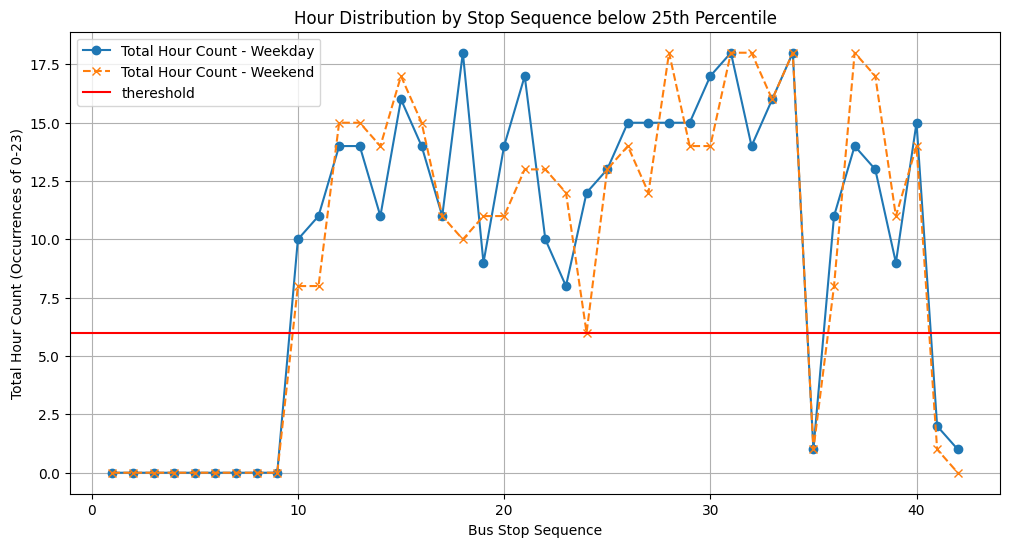

Percentage of stop sequences exceeding 6 in Weekday: 71.43%
Percentage of stop sequences exceeding 6 in Weekend: 69.05%


In [42]:
# Step 1: Count occurrences of each TIME_PER_HOUR per StopSequence, DAY_TYPE, and Direction
hour_counts = (
    merged_data.groupby(['StopSequence', 'DAY_TYPE', 'Direction'])
    .size()
    .reset_index(name='Total_Hour_Count')
)

# Step 2: Generate all StopSequence, DAY_TYPE, and Direction combinations for filling missing values
max_sequence = merged_data['StopSequence'].max()
directions = merged_data['Direction'].unique()
day_types = merged_data['DAY_TYPE'].unique()
full_index = pd.MultiIndex.from_product(
    [range(1, max_sequence + 1), day_types, directions], 
    names=['StopSequence', 'DAY_TYPE', 'Direction']
)

# Step 3: Reindex hour_counts to include all combinations, filling missing values with 0
hour_counts = hour_counts.set_index(['StopSequence', 'DAY_TYPE', 'Direction']).reindex(full_index, fill_value=0).reset_index()

# Step 4: Separate data by day type
weekday_data = hour_counts[hour_counts['DAY_TYPE'] == 'WEEKDAY']
weekend_data = hour_counts[hour_counts['DAY_TYPE'] == 'WEEKENDS/HOLIDAY']

# Step 5: Filter only direction 1 as we are only interested in direction 1 
weekday_data_dir1 = weekday_data[weekday_data['Direction'] == 1]
weekend_data_dir1 = weekend_data[weekend_data['Direction'] == 1]


# Plotting function for both directions on the same graph
def plot_hour_distribution(weekday, weekend, title):
    plt.figure(figsize=(12, 6))
    
    # Plot Weekday
    plt.plot(weekday['StopSequence'], weekday['Total_Hour_Count'], label="Total Hour Count - Weekday", marker='o')
    
    # Plot Weekend
    plt.plot(weekend['StopSequence'], weekend['Total_Hour_Count'], label="Total Hour Count - Weekend", marker='x', linestyle='--')
    plt.axhline(y=6, color='r', linestyle='-', label='thereshold')
    # Adding labels and title
    plt.xlabel("Bus Stop Sequence")
    plt.ylabel("Total Hour Count (Occurrences of 0-23)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for weekday and weekend for directions 1
plot_hour_distribution(weekday_data_dir1, weekend_data_dir1, "Hour Distribution by Stop Sequence below 25th Percentile")


# Define threshold
threshold = 6

# Calculate total sequences and sequences exceeding threshold for each direction
total_sequences_weekday = weekday_data_dir1.shape[0]
exceeding_sequences_weekday = weekday_data_dir1[weekday_data_dir1['Total_Hour_Count'] > threshold].shape[0]

total_sequences_weekend = weekend_data_dir1.shape[0]
exceeding_sequences_weekend = weekend_data_dir1[weekend_data_dir1['Total_Hour_Count'] > threshold].shape[0]

# Calculate percentages
percentage_exceed_weekday = (exceeding_sequences_weekday / total_sequences_weekday) * 100 if total_sequences_weekday else 0
percentage_exceed_weekend = (exceeding_sequences_weekend / total_sequences_weekend) * 100 if total_sequences_weekend else 0

# Display the results
print(f"Percentage of stop sequences exceeding {threshold} in Weekday: {percentage_exceed_weekday:.2f}%")
print(f"Percentage of stop sequences exceeding {threshold} in Weekend: {percentage_exceed_weekend:.2f}%")
